<h1 align="center">Crowd Counting Project</h1>


# Imports


In [634]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as sm
import matplotlib.pyplot as plt

from PIL import Image
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit

# Add annotations for easier usage


In [635]:
# Load annotations and create DataFrame
gt = loadmat("mall_dataset/ground_truth.mat")
df = pd.DataFrame({
    'head_count': gt['count'].flatten(),
    'annotations': [frame_df[0][0][0] for frame_df in gt['frame'][0]]})
df['head_count'] = df['head_count'].astype(int)

df = df.reset_index()
df = df.rename({'index': 'frame_id'}, axis=1)
df.frame_id = df.index + 1

df['image_name'] = df['frame_id'].apply(lambda x: f'seq_{x:06d}.jpg')

# Load perspective map
pMap = loadmat('mall_dataset/perspective_roi.mat')['pMapN']
df

,frame_id,head_count,annotations,image_name
0,1,29,"[[126.77986348122866, 60.70477815699661], [116...",seq_000001.jpg
1,2,30,"[[57.155290102389046, 199.13481228668945], [87...",seq_000002.jpg
2,3,35,"[[118.73899371069183, 43.77044025157227], [134...",seq_000003.jpg
3,4,31,"[[140.87735849056602, 44.77672955974833], [151...",seq_000004.jpg
4,5,26,"[[123.77044025157232, 51.82075471698107], [145...",seq_000005.jpg
...,...,...,...,...
1995,1996,27,"[[454.8737166324436, 45.34599589322369], [462....",seq_001996.jpg
1996,1997,27,"[[367.48151950718693, 59.14476386036961], [395...",seq_001997.jpg
1997,1998,25,"[[22.512320328542103, 245.09958932238186], [73...",seq_001998.jpg
1998,1999,26,"[[22.512320328542103, 290.43839835728943], [99...",seq_001999.jpg


# Load the data


In [636]:
frames_folder_path = 'mall_dataset/frames'

In [637]:
frame_files = [f for f in os.listdir(frames_folder_path) if f.endswith(('.jpg', '.jpeg'))]
frame_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

frames = []
for frame_file in frame_files:
    frame_path = os.path.join(frames_folder_path, frame_file)
    frame = Image.open(frame_path)
    frames.append(frame)

# Exploratory Data Analysis (EDA)


## Basic information


In [638]:
print("Count of frames:", len(frames))

Count of frames: 2000


In [639]:
frames[0].size

(640, 480)

## Plot sample image with and without annotation


### Without annotation


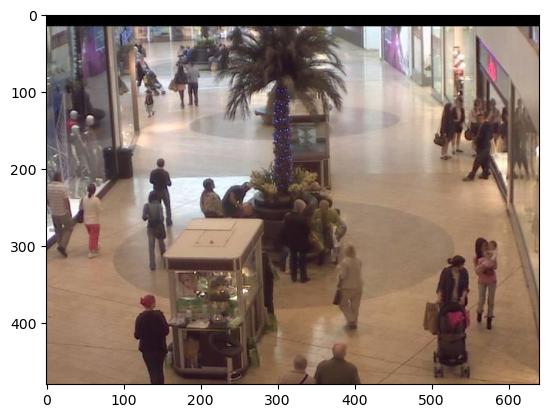

In [640]:
sample_image = plt.imshow(frames[0])

### With annotation


Head count: 29


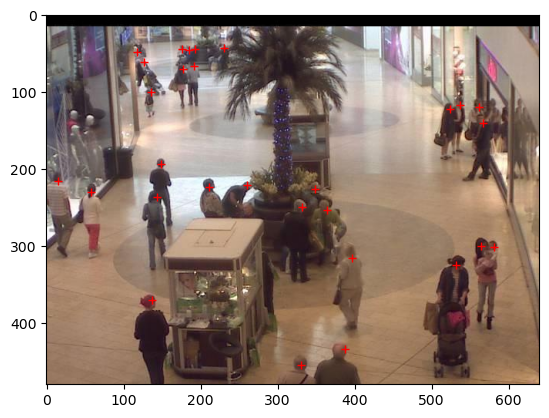

In [641]:
annotations = df.loc[0, 'annotations']

print("Head count:", df.head_count[0])

plt.imshow(frames[0])
for annotation in annotations:
    x, y = annotation
    plt.plot(x, y, 'r+')
plt.show()

## Basic information & plots of the head counts (labels)


In [642]:
df.head_count.describe()

count    2000.000000
mean       31.157500
std         6.945417
min        13.000000
25%        26.000000
50%        31.000000
75%        36.000000
max        53.000000
Name: head_count, dtype: float64

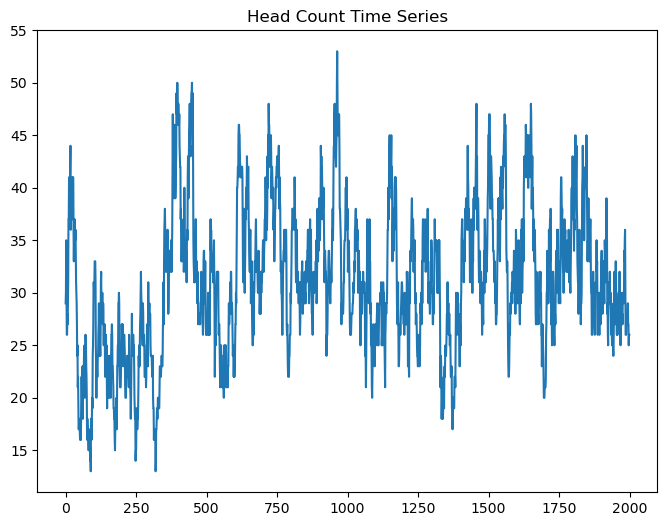

In [643]:
# Time series plot
plt.figure(figsize=(8, 6))
df.head_count.plot()
plt.title('Head Count Time Series')
plt.show()

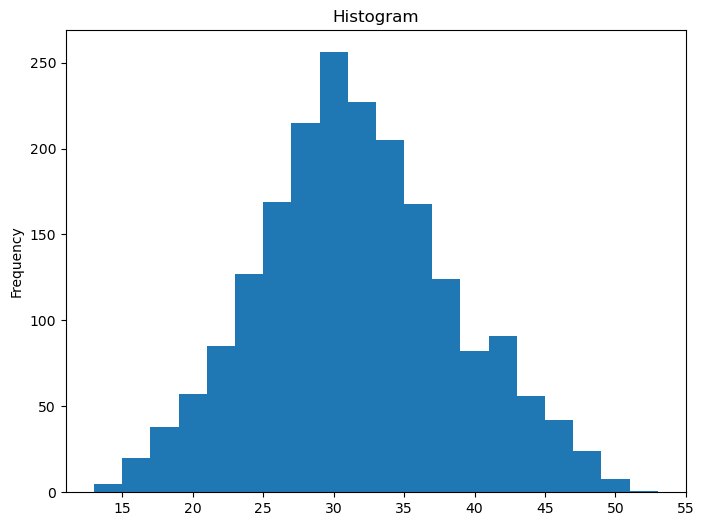

In [644]:
# Histogram plot
plt.figure(figsize=(8, 6))
df.head_count.plot(kind='hist', bins=20)
plt.title('Histogram')
plt.show()

<Figure size 1200x800 with 0 Axes>

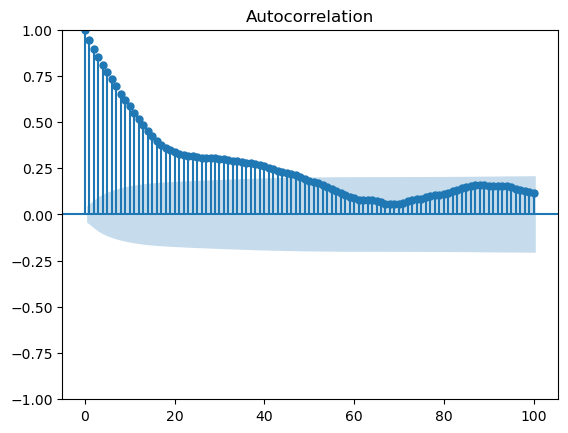

In [645]:
# ACF plot
plt.figure(figsize=(12, 8))
sm.graphics.tsaplots.plot_acf(df.head_count, lags=100)
plt.show()

<Figure size 1200x800 with 0 Axes>

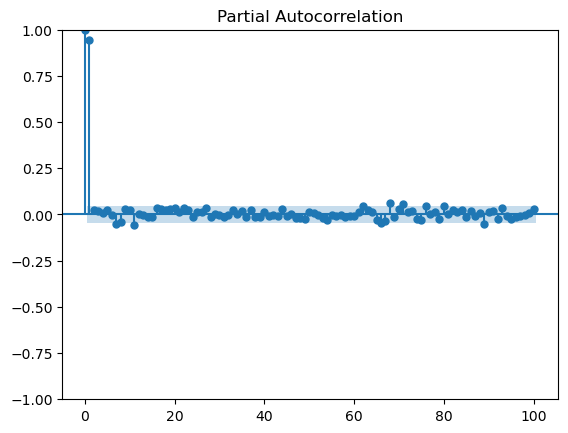

In [646]:
# PACF plot
plt.figure(figsize=(12, 8))
sm.graphics.tsaplots.plot_pacf(df.head_count, lags=100)
plt.show()

In [647]:
# Compute the difference between consecutive frames
df['net_change'] = df['head_count'].diff().fillna(0)

In [648]:
# Detect changes in head_count
df['change'] = df['net_change'] != 0

In [649]:
# Identify the frame indices where changes occur
change_indices = df[df['change']].index

In [650]:
# Calculate intervals between changes
intervals = change_indices[1:] - change_indices[:-1]
intervals = np.array(intervals)

In [651]:
# Calculate frequencies of each interval
interval_counts = pd.Series(intervals).value_counts().reset_index()
interval_counts.columns = ['interval', 'frequency']

In [652]:
# Exponential fit function
def exponential_fit(x, a, b):
    return a * np.exp(b * x)

In [653]:
pars, cov = curve_fit(f=exponential_fit, xdata=interval_counts['interval'], ydata=interval_counts['frequency'], p0=[0, 0])

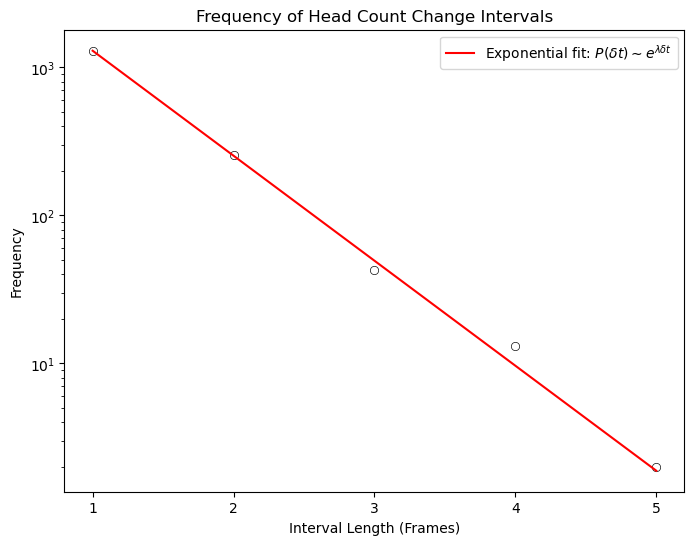

In [654]:
# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(data=interval_counts, x='interval', y='frequency', edgecolor='black', color='white')
plt.plot(interval_counts['interval'], exponential_fit(interval_counts['interval'], *pars), color='red', label=f'Exponential fit: $P(\\delta t) \\sim e^{{\\lambda \\delta t}}$')

# Set y-axis to log scale
plt.yscale('log')
plt.xticks(range(1, interval_counts['interval'].max() + 1, 1))

# Adding title and labels
plt.title('Frequency of Head Count Change Intervals')
plt.xlabel('Interval Length (Frames)')
plt.ylabel('Frequency')
plt.legend()

plt.show()

## Density map


In [655]:
# Function to create a density map
def create_density_map(image_shape, head_locations, sigma=20):
    density_map = np.zeros(image_shape[:2])
    for x, y in head_locations:
        density_map[int(y)-1, int(x)-1] += 1
    return gaussian_filter(density_map, sigma=sigma)

In [656]:
# Image dimensions
height, width = 480, 640
frame_id = 1

In [657]:
# Aggregate all head locations from the dataset
all_head_locations = [point for idx, row in df.iterrows() for point in row['annotations']]

In [658]:
# Create the density map
density_map = create_density_map((height, width), all_head_locations)

In [659]:
# Apply logarithmic scaling to the density map
# Adding 1 before log to avoid log(0)
log_density_map = np.log(density_map + 1)

In [660]:
# Normalize the log-scaled density map for overlaying
density_map_normalized = log_density_map / np.max(log_density_map)
heatmap = plt.cm.jet(density_map_normalized)  # Apply a colormap where high values are red and low are blue

In [661]:
# Convert heatmap to RGB and ensure it is in uint8
heatmap_rgb = (heatmap[..., :3] * 255).astype(np.uint8)

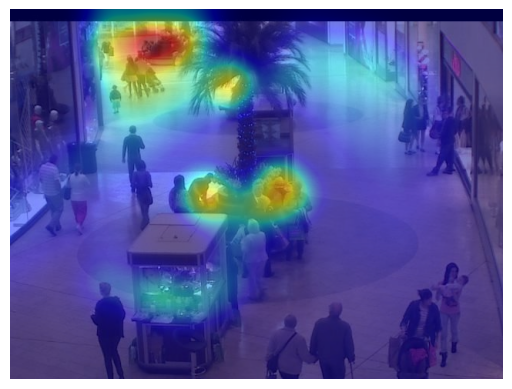

In [662]:
# Load a frame and ensure it is in the right format and scale
background_path = 'mall_dataset/frames/' + df.image_name.iloc[frame_id]
background = cv2.imread(background_path)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
if background.dtype != np.uint8:
    background = (background * 255).astype(np.uint8)

# Overlay the heatmap on the first frame
overlayed_image = cv2.addWeighted(background, 0.5, heatmap_rgb, 0.5, 0)

# Plot the overlayed image
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()